# Analysis and Modeling of calls to San Francisco Fire Department

This project is to implement the exploratory analysis plan for Analysing 911 calls assigned to San Francisco Fire Department (SFFD).

Data of Calls to SFFD has been downloaded from https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3 . A subset of data from Dec 31, 2016 to January 7, 2017 is used for Analysis here.

> ### Hypothesis

Location and time of the day will help in measuring the call traffic on the Battalions of San Francisco Fire Department

In [2]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model, cross_validation, preprocessing, neighbors, grid_search, metrics

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
%matplotlib inline
plt.style.use('ggplot')

from pygeocoder import Geocoder,GeocoderError
import geopandas as gp

from mpl_toolkits.basemap import Basemap
import fiona
from fiona.crs import from_epsg
from pyproj import Proj, transform
from descartes import PolygonPatch
from shapely.geometry import shape, mapping
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

import time
from itertools import chain

> ### Read Dataset

In [3]:
df = pd.read_csv('Fire_Department_Calls_for_Service.csv')

In [3]:
df.head()

,Call Number,Unit ID,Incident Number,Call Type,Call Date,...,Fire Prevention District,Supervisor District,Neighborhood District,Location,RowID
0,163664050,E39,16146990,Citizen Assist / Service Call,12/31/2016,...,8,7,West of Twin Peaks,"(37.745858648581, -122.456664252061)",163664050-E39
1,163664036,E38,16146989,Medical Incident,12/31/2016,...,4,2,Marina,"(37.8051625655624, -122.432957440518)",163664036-E38
2,163664036,AM30,16146989,Medical Incident,12/31/2016,...,4,2,Marina,"(37.8051625655624, -122.432957440518)",163664036-AM30
3,163664020,E10,16146988,Outside Fire,12/31/2016,...,4,2,Pacific Heights,"(37.7885701888359, -122.44394001715)",163664020-E10
4,163664007,KM204,16146987,Medical Incident,12/31/2016,...,2,9,Mission,"(37.7643732096664, -122.417478491468)",163664007-KM204


> ### Number of Observations 

In [17]:
df.shape

(7704, 34)

> ### Exploring the features in the Dataset

A description of the dataset is as follows:

- Call Number: A unique 9-digit number assigned by the 911 Dispatch Center (DEM) to this call. These number are used for both Police and Fire calls.

- Unit ID 

- Incident Number: A unique 8-digit number assigned by DEM to this Fire incident.

- Call Type

- Call Date: Date the call is received at the 911 Dispatch Center.

- Watch Date: Watch date when the call is received. Watch date starts at 0800 each morning and ends at 0800 the next day.

- Received DtTm: Date and time of call is received at the 911 Dispatch Center.

- Entry DtTm: Date and time the 911 operator submits the entry of the initical call information into the CAD system

- Dispatch DtTm: Date and time the 911 operator dispatches this unit to the call.

- Response DtTm: Date and time this unit acknowledges the dispatch and records that the unit is en route to the location of the call.

- On Scene DtTm: Date and time the unit records arriving to the location of the incident

- Transport DtTm: If this unit is an ambulance, date and time the unit begins the transport unit arrives to hospital

- Hospital DtTm: If this unit is an ambulance, date and time the unit arrives to the hospital.

- Call Final Disposition: Disposition of the call (Code). For example TH2: Transport to Hospital  Code 2, FIR: Resolved by Fire Department

- Available DtTm: Date and time this unit is not longer assigned to this call and it is available for another dispatch.

- Address: Address of incident (note: address and location generalized to mid-block of street, intersection or nearest call box location, to protect caller privacy).

- City

- Zipcode of Incident

- Battalion: Emergency Response District (There are 9 Fire Emergency Response Districts)

- Station Area: Fire Station First Response Area associated with the address of the incident

- Box: Fire box associated with the address of the incident. A box is the smallest area used to divide the City. Each box is associated with a unique unit dispatch order. The City is divided into more than 2,400 boxes.

- Original Priority: Initial call priority (Code 2: Non-Emergency or Code 3:Emergency).

- Priority: Call priority (Code 2: Non-Emergency or Code 3:Emergency).

- Final Priority: Final call priority (Code 2: Non-Emergency or Code 3:Emergency).

- ALS Unit: Does this unit includes ALS (Advance Life Support) resources? Is there a paramedic in this unit?

- Call Type Group: Call types are divided into four main groups: Fire, Alarm, Potential Life Threatening and Non Life Threatening.

- Number of Alarms: Number of alarms associated with the incident. This is a number between 1 and 5.

- Unit Type: A number that indicates the order this unit was assigned to this call

- Unit sequence in call dispatch

- Fire Prevention District: Bureau of Fire Prevention District associated with this address

- Supervisor District: Supervisor District associated with this address (note: these are the districts created in 2012).

- Neighborhood  District: Neighborhood District associated with this address

- Location: Location of incident (note: address and location generalized to mid-block of street, intersection or nearest call box location, to protect caller privacy).

- RowID: Unique Call Number and Unit ID combination

In [6]:
with pd.option_context('display.max_rows', 999):
    print(df.dtypes)

Call Number                         int64
Unit ID                            object
Incident Number                     int64
Call Type                          object
Call Date                          object
Watch Date                         object
Received DtTm                      object
Entry DtTm                         object
Dispatch DtTm                      object
Response DtTm                      object
On Scene DtTm                      object
Transport DtTm                     object
Hospital DtTm                      object
Call Final Disposition             object
Available DtTm                     object
Address                            object
City                               object
Zipcode of Incident               float64
Battalion                          object
Station Area                      float64
Box                                 int64
Original Priority                  object
Priority                           object
Final Priority                    

> ### Creating a summary table.

In [7]:
df.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Call Number,Incident Number,Zipcode of Incident,Station Area,Box,Final Priority,Number of Alarms,Unit sequence in call dispatch
count,7.704000e+03,7.704000e+03,7700.000000,7701.000000,7704.000000,7704.000000,7704.000000,7704.000000
mean,1.693360e+08,1.690712e+07,94113.040000,18.159590,4023.344367,2.701584,1.002985,2.083463
std,2.001008e+06,2.681311e+05,10.173222,14.720843,2325.432036,0.457593,0.054561,1.816641
min,1.636600e+08,1.614656e+07,94102.000000,1.000000,231.000000,2.000000,1.000000,1.000000
25%,1.700138e+08,1.700051e+07,NaN,NaN,2123.000000,2.000000,1.000000,1.000000
50%,1.700403e+08,1.700146e+07,NaN,NaN,3412.000000,3.000000,1.000000,2.000000
75%,1.700541e+08,1.700234e+07,NaN,NaN,5728.000000,3.000000,1.000000,2.000000
max,1.700736e+08,1.700330e+07,94158.000000,51.000000,9944.000000,3.000000,2.000000,23.000000


> ### Data points will null data

In [8]:
with pd.option_context('display.max_rows', 999):
    print(df.isnull().sum())

Call Number                          0
Unit ID                              0
Incident Number                      0
Call Type                            0
Call Date                            0
Watch Date                           0
Received DtTm                        0
Entry DtTm                           0
Dispatch DtTm                        0
Response DtTm                      214
On Scene DtTm                     1554
Transport DtTm                    5441
Hospital DtTm                     5496
Call Final Disposition               0
Available DtTm                       5
Address                              0
City                                14
Zipcode of Incident                  4
Battalion                            0
Station Area                         3
Box                                  0
Original Priority                    0
Priority                             0
Final Priority                       0
ALS Unit                             0
Call Type Group          

> ### Plotting the frequency of Battalions

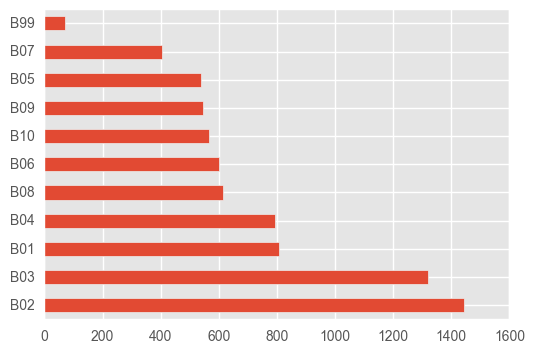

In [9]:
df['Battalion'].value_counts(dropna = False).plot(kind='barh')

> ### Plotting the frequency of the type of calls

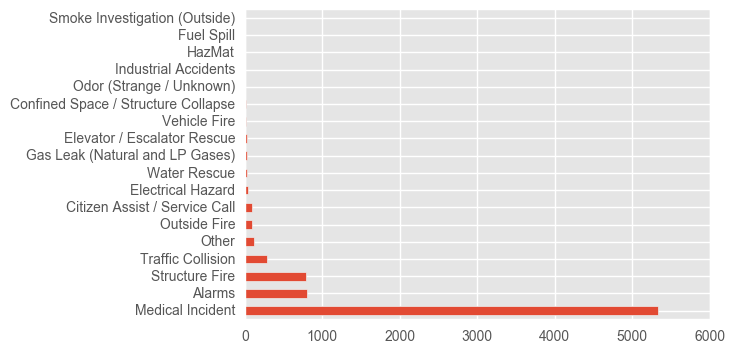

In [10]:
df['Call Type'].value_counts(dropna = False).plot(kind='barh')

> ### Plotting the call frequency at various Neighborhoods

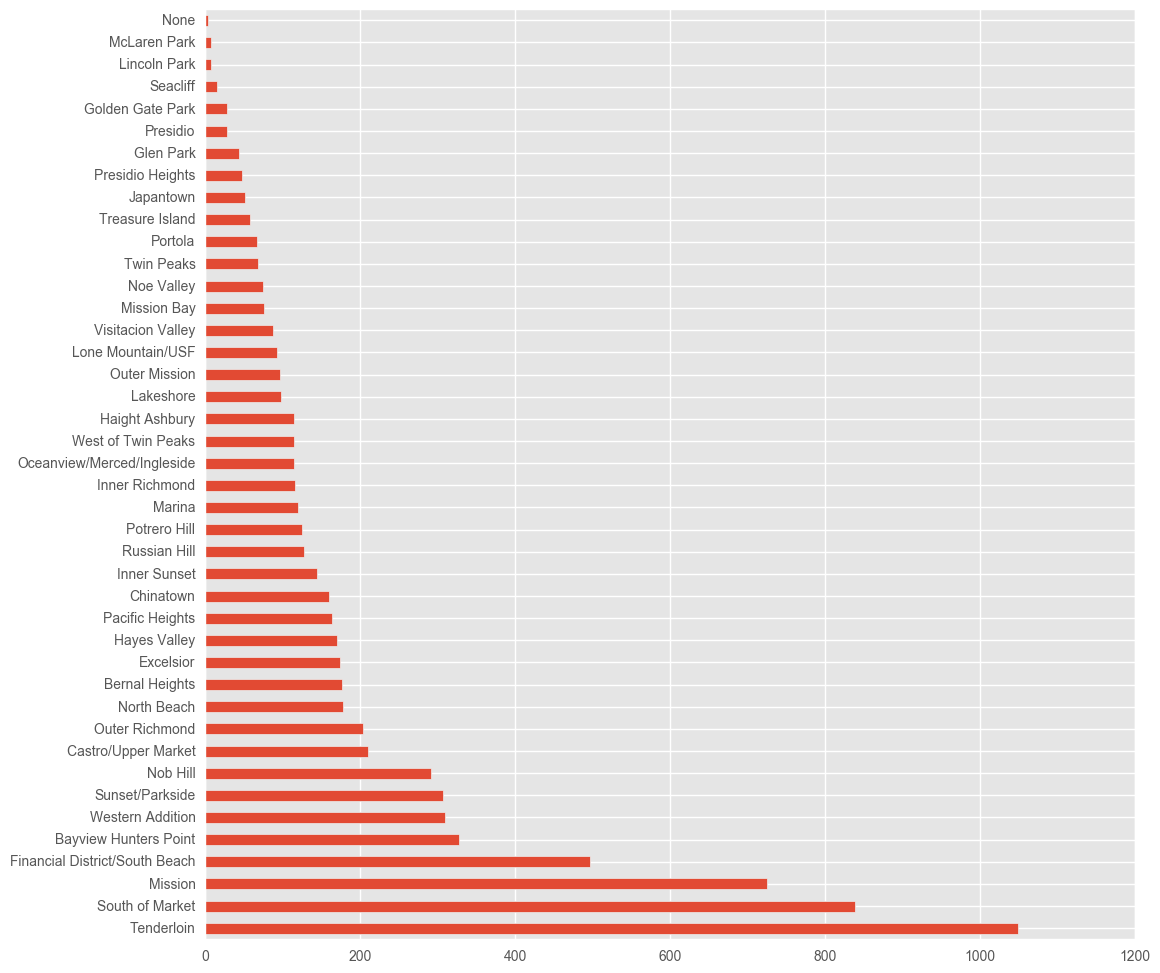

In [11]:
df['Neighborhood  District'].value_counts(dropna = False).plot(kind='barh', figsize = (12,12))

> ### Plotting distributions for numeric features

In [12]:
df.dtypes.value_counts()

object     25
int64       6
float64     2
bool        1
dtype: int64

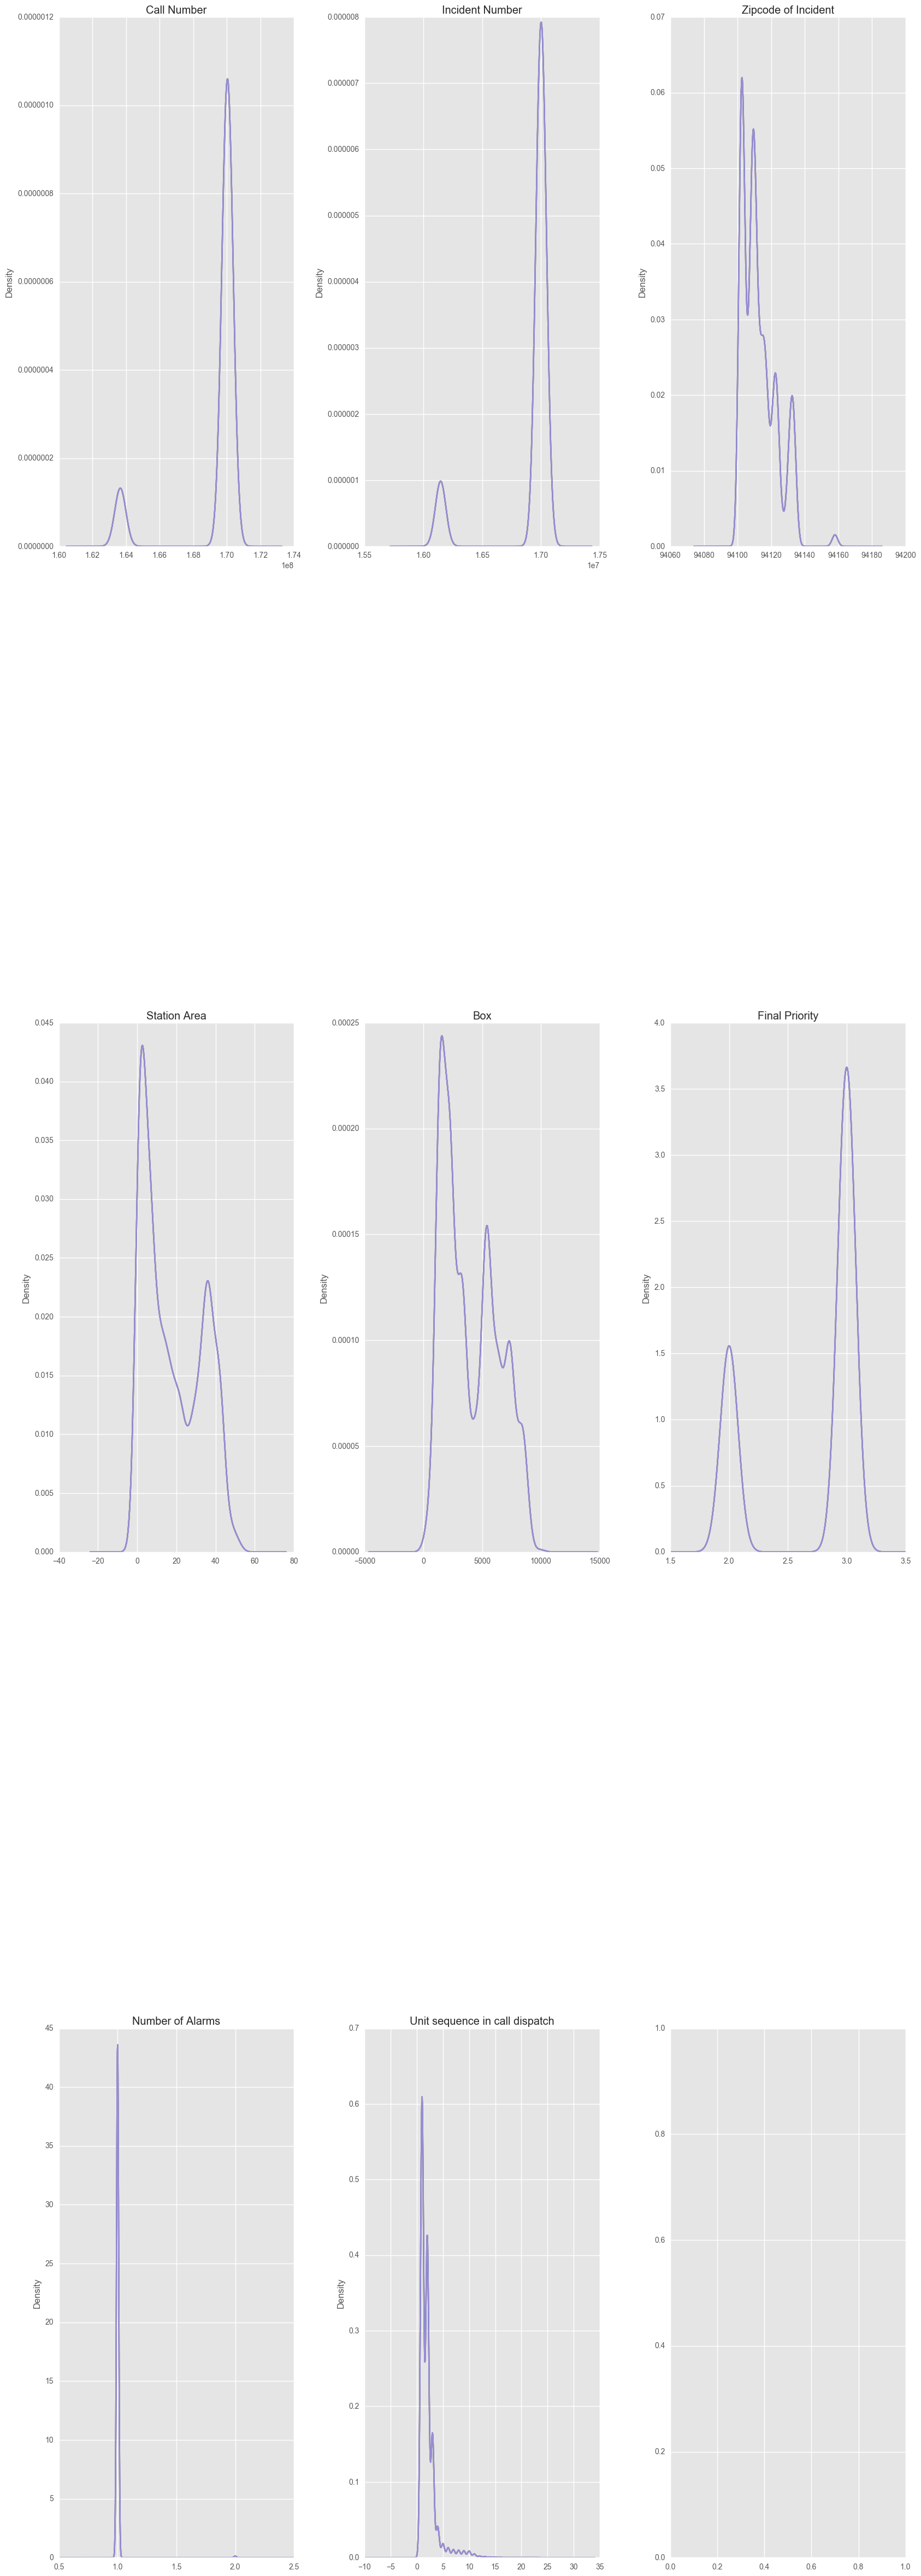

In [13]:
num_df = df.select_dtypes(include=['float64','int64'])
n_cols = 3
n_rows = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize = (20,60))

fig.subplots_adjust(hspace=.9, wspace=.3)

for k in axs:
    for i,j in zip(num_df, axs.flat):
        g = num_df[i].plot.kde(ax = j, title = i)

# Dummy Variables 

In [4]:
# Create a set of dummy variables from the Battalion variable
df_Battalion = pd.get_dummies(df['Battalion'])

In [5]:
df_Call_Type = pd.get_dummies(df['Call Type'])

In [6]:
df_Neighborhood_District = pd.get_dummies(df['Neighborhood  District'])

In [7]:
# Create a set of dummy variables
df_with_dummies = pd.get_dummies(df['Battalion'],df['Call Type'],df['Neighborhood  District'] )

In [8]:
df = df.join(df_Battalion)

In [9]:
df = df.join(df_Call_Type)

In [10]:
df = df.join(df_Neighborhood_District) 

In [11]:
df.shape

(7704, 105)

In [35]:
for row in df.columns:
    print(row)

Call Number
Unit ID
Incident Number
Call Type
Call Date
Watch Date
Received DtTm
Entry DtTm
Dispatch DtTm
Response DtTm
On Scene DtTm
Transport DtTm
Hospital DtTm
Call Final Disposition
Available DtTm
Address
City
Zipcode of Incident
Battalion
Station Area
Box
Original Priority
Priority
Final Priority
ALS Unit
Call Type Group
Number of Alarms
Unit Type
Unit sequence in call dispatch
Fire Prevention District
Supervisor District
Neighborhood  District
Location
RowID
B01
B02
B03
B04
B05
B06
B07
B08
B09
B10
B99
Alarms
Citizen Assist / Service Call
Confined Space / Structure Collapse
Electrical Hazard
Elevator / Escalator Rescue
Fuel Spill
Gas Leak (Natural and LP Gases)
HazMat
Industrial Accidents
Medical Incident
Odor (Strange / Unknown)
Other
Outside Fire
Smoke Investigation (Outside)
Structure Fire
Traffic Collision
Vehicle Fire
Water Rescue
Bayview Hunters Point
Bernal Heights
Castro/Upper Market
Chinatown
Excelsior
Financial District/South Beach
Glen Park
Golden Gate Park
Haight Ashbu

>### Correlation of the features

In [51]:
num_df = df.select_dtypes(include=['float64','int64'])

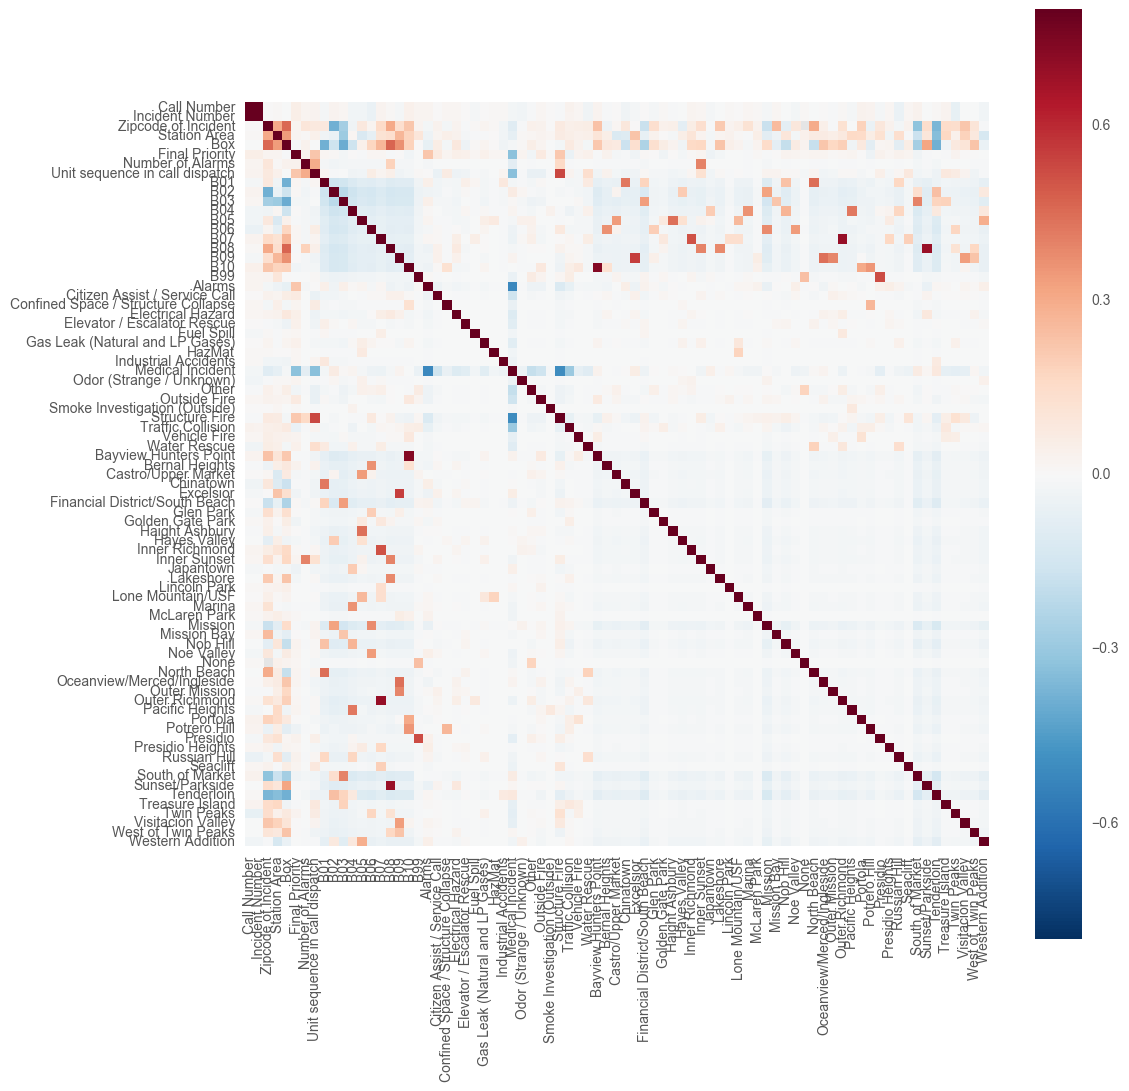

In [55]:
corrmat = num_df.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True)

In [12]:
incident_df = df[['Alarms','Citizen Assist / Service Call','Confined Space / Structure Collapse','Electrical Hazard','Elevator / Escalator Rescue','Fuel Spill','Gas Leak (Natural and LP Gases)','HazMat','Industrial Accidents','Medical Incident','Odor (Strange / Unknown)','Other','Outside Fire','Smoke Investigation (Outside)','Structure Fire','Traffic Collision','Vehicle Fire','Water Rescue']]

In [13]:
battalion_df = df[['B01',
'B02',
'B03',
'B04',
'B05',
'B06',
'B07',
'B08',
'B09',
'B10',
'B99']]

In [14]:
corr_df = incident_df.join(battalion_df) 

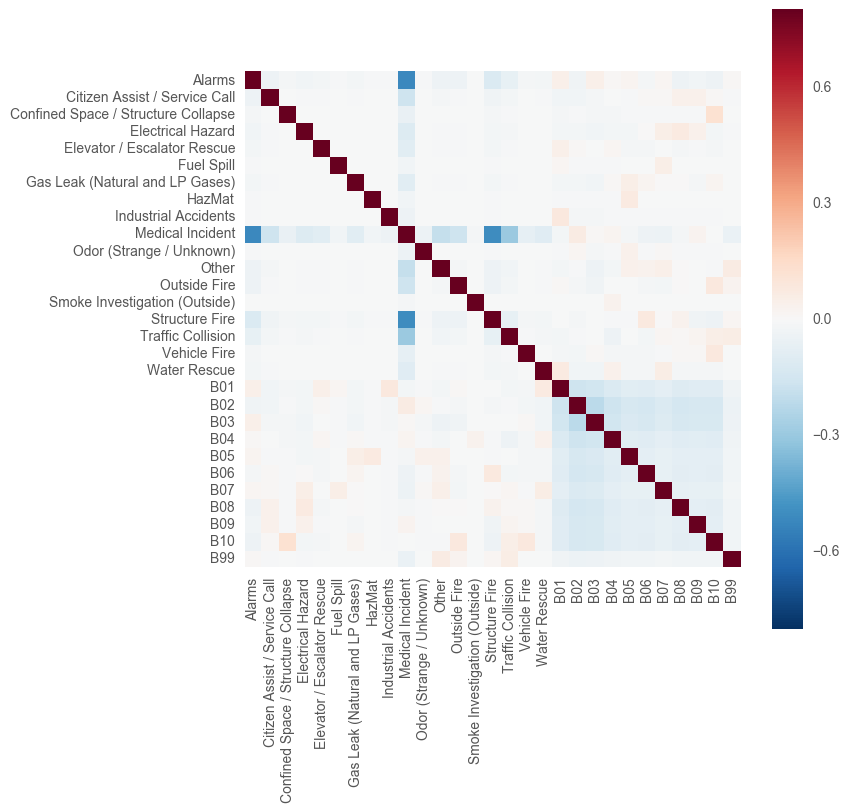

In [69]:
corrsub1 = corr_df.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrsub1, vmax=.8, square=True)

# Modeling

In [ ]:
X = df[[      
        'B01',
'B02',
'B03',
'B04',
'B05',
'B06',
'B07',
'B08',
'B09',
'B10',
'B99'
    ]]

y = df['Box']

c_Medical = df['Medical Incident']

> ### Linear Regression Model for features Box and Battaion

In [89]:
model = linear_model.LinearRegression()
model.fit(X,y)

print(model.intercept_)
print(model.coef_)

3.81671588699e+13
[ -3.81671589e+13  -3.81671589e+13  -3.81671589e+13  -3.81671589e+13
  -3.81671589e+13  -3.81671589e+13  -3.81671589e+13  -3.81671589e+13
  -3.81671589e+13  -3.81671589e+13  -3.81671589e+13]


In [90]:
model.score(X, y)

0.75490347821167647

>### Regularization

In [80]:
model_linear = smf.OLS(y, X).fit()

model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Box   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     2369.
Date:                Tue, 21 Feb 2017   Prob (F-statistic):               0.00
Time:                        12:51:12   Log-Likelihood:                -65233.
No. Observations:                7704   AIC:                         1.305e+05
Df Residuals:                    7693   BIC:                         1.306e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
B01         1410.5198     40.527     34.804      0.000      1331.075  1489.965
B02         3224.8947     30.316    106.376      0.000      3165.467  3284.322
B03         1997.3649     31.696     63.017      0.000      1935.232  2059.497
B04         2892.2544     40.883     70.744      0.000      2812.112  2972.396
B05         4380.3296     49.713     88.113      0.000      4282.879  4477.780
B06         5380.2907     46.952    114.591      0.000      5288.252  5472.330
B07         6639.5866     57.314    115.845      0.000      6527.235  6751.938
B08         7682.5896     46.491    165.249      0.000      7591.454  7773.725
B09         7089.1927     49.346    143.662      0.000      6992.460  7185.925
B10         5529.7403     48.422    114.198      0.000      5434.819  5624.661
B99         4062.4638    138.685     29.293      0.000      3790.603  4334.324
==============================================================================
Omnibus:                     1710.125   Durbin-Watson:                   0.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6987.085
Skew:                          -1.044   Prob(JB):                         0.00
Kurtosis:                       7.172   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>### Logistic Regression

In [92]:
model_Logistic = linear_model.LogisticRegression().\
    fit(X, y)

print(model_Logistic.coef_)
print(model_Logistic.intercept_)

[[-0.84901669 -1.13740763  1.02344627 ..., -0.67881472 -0.69420651
  -0.14623004]
 [-0.72044296 -0.986722   -0.94299563 ..., -0.56663557 -0.01791587
  -0.11286082]
 [-0.80770925  0.52772666 -1.0434329  ..., -0.64253355 -0.65743443
  -0.13502367]
 ..., 
 [-0.77976542 -1.056729   -1.01145331 ..., -0.61810971 -0.63266337
  -0.12765616]
 [-0.81784474 -1.10120452 -1.05500691 ..., -0.6514075  -0.66643167
  -0.1377343 ]
 [-0.85872224 -1.14865272 -1.10152599 ..., -0.68735593  1.52754715
  -0.14894408]]
[-6.00815493 -6.30113407 -6.09940802 ..., -6.1626084  -6.07679553
 -5.9870836 ]


In [93]:
model_Logistic.score(X, y)

0.055944963655244026

>### Statsmodel

In [81]:
model = smf.ols(formula = 'Alarms ~ B01', data = df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Alarms   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     15.35
Date:                Tue, 21 Feb 2017   Prob (F-statistic):           9.01e-05
Time:                        12:53:49   Log-Likelihood:                -1811.0
No. Observations:                7704   AIC:                             3626.
Df Residuals:                    7702   BIC:                             3640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1002      0.004     27.181      0.000         0.093     0.107
B01            0.0446      0.011      3.918      0.000         0.022     0.067
==============================================================================
Omnibus:                     3788.763   Durbin-Watson:                   0.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15394.009
Skew:                           2.572   Prob(JB):                         0.00
Kurtosis:                       7.637   Cond. No.                         3.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> ### KNN

In [76]:
model_knn = neighbors.KNeighborsClassifier(n_neighbors = 1).\
    fit(X, y)

In [78]:
model_knn.score(X, y)

0.011682242990654205

>### Logistic Regression

In [83]:
model_Medical = linear_model.LogisticRegression()
model_Medical.fit(X, c_Medical)
c_hat_Medical = model_Medical.predict(X)

In [87]:
model_Medical.score(X, c_Medical)

0.69340602284527519

>### Confusion Matrix

In [88]:
pd.crosstab(c_Medical,
    c_hat_Medical,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class'])

True Class,0.0,1.0
Hypothesized Class,,
0.0,40,2333
1.0,29,5302


# Time Series

In [15]:
df['Received DtTm'] = pd.to_datetime(df['Received DtTm'])

In [16]:
df.set_index('Received DtTm', inplace = True)

In [17]:
df['Day'] = df.index.day

In [18]:
df['Hour'] = df.index.hour

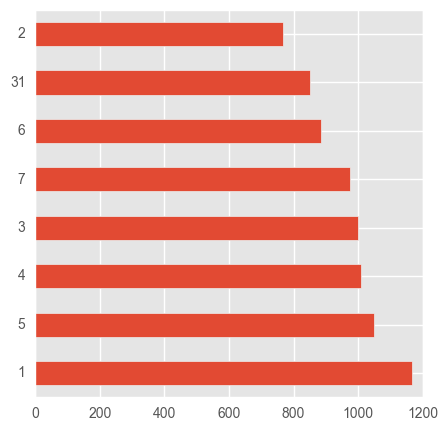

In [19]:
df['Day'].value_counts().plot(kind='barh', figsize = (5,5))

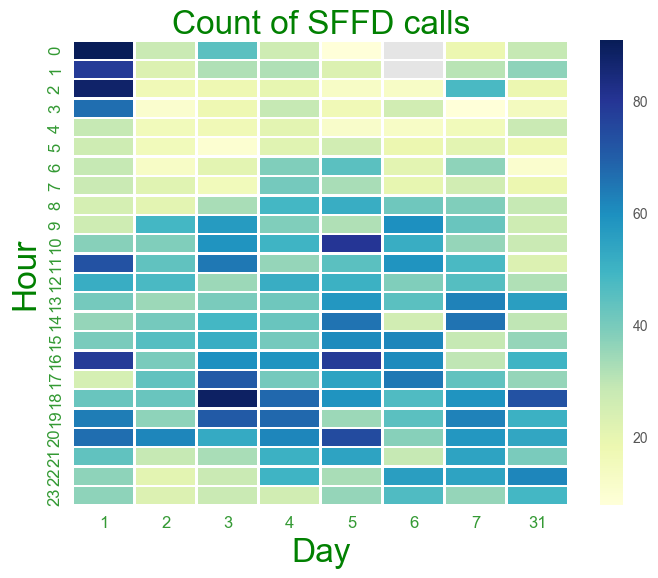

In [94]:
plt.figure(figsize=(8,6))
call_counts = pd.DataFrame({'count' : df.groupby( [ "Hour","Day"] ).size()}).reset_index() 
call_counts_pivot = call_counts.pivot("Hour","Day","count") 
ax = sns.heatmap(call_counts_pivot, annot=False, fmt="d", linewidths=1, square = False, cmap="YlGnBu")
ax = plt.xticks(fontsize = 12,color="green", alpha=0.8)
ax = plt.yticks(fontsize = 12,color="green", alpha=0.8)
ax = plt.xlabel("Day", fontsize = 24, color="green")
ax = plt.ylabel("Hour", fontsize = 24, color="green")
ax = plt.title("Count of SFFD calls", fontsize = 24, color="green")

# GeoCoding

Shape file source : https://github.com/sfroid/sfcoord2nbh/tree/master/sffind_neighborhoods

In [236]:
df = df[df.Day == 1]

In [237]:
df.shape

(1166, 34)

In [201]:
latitude = []
longitude = []
for row in df.Address:
        try:
            results  = Geocoder.geocode(row)
            latitude.append(results.coordinates[0])
            longitude.append(results.coordinates[1])
            time.sleep(1)
        except GeocoderError:
            latitude.append(0.0)
            longitude.append(0.0)

In [252]:
df['latitude'] = latitude

In [256]:
df['longitude'] = longitude

In [120]:
shapefile="/Users/nikita/Documents/DS-SF-30/final-project/datasets/sf_neighborhoods/SFFind_Neighborhoods.shp"
shp = fiona.open(shapefile)
bds = shp.bounds
print (bds)

shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

(-122.5148972319999, 37.708089209000036, -122.35698198799994, 37.83239597600004)


(117,
 5,
 [-122.5148972319999, 37.708089209000036, 0.0, 0.0],
 [-122.35698198799994, 37.83239597600004, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x120a24630>)

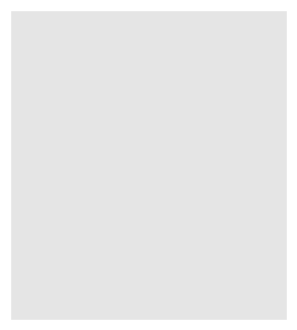

In [248]:
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    '/Users/nikita/Documents/DS-SF-30/final-project/datasets/sf_neighborhoods/SFFind_Neighborhoods',
    'SF',
    color='none',
    zorder=2)


In [269]:
call_pts=df[['longitude','latitude']]
call_pts.columns

Index(['longitude', 'latitude'], dtype='object')

In [373]:
def get_marker_color(cltp):
        if cltp == 'Medical Incident':
            return ('ro')
        elif cltp == 'Structure Fire':
            return ('yo')
        elif cltp == 'Alarms':
            return ('wo')
        elif cltp == 'Traffic Collision':
            return ('bo')
        else:
            return ('go')

call_type_clr = []
for row in df['Call Type']:
    call_type_clr.append(get_marker_color(row))

In [280]:
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['longitude'], df['latitude'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))

ldn_points = filter(wards_polygon.contains, plaque_points)

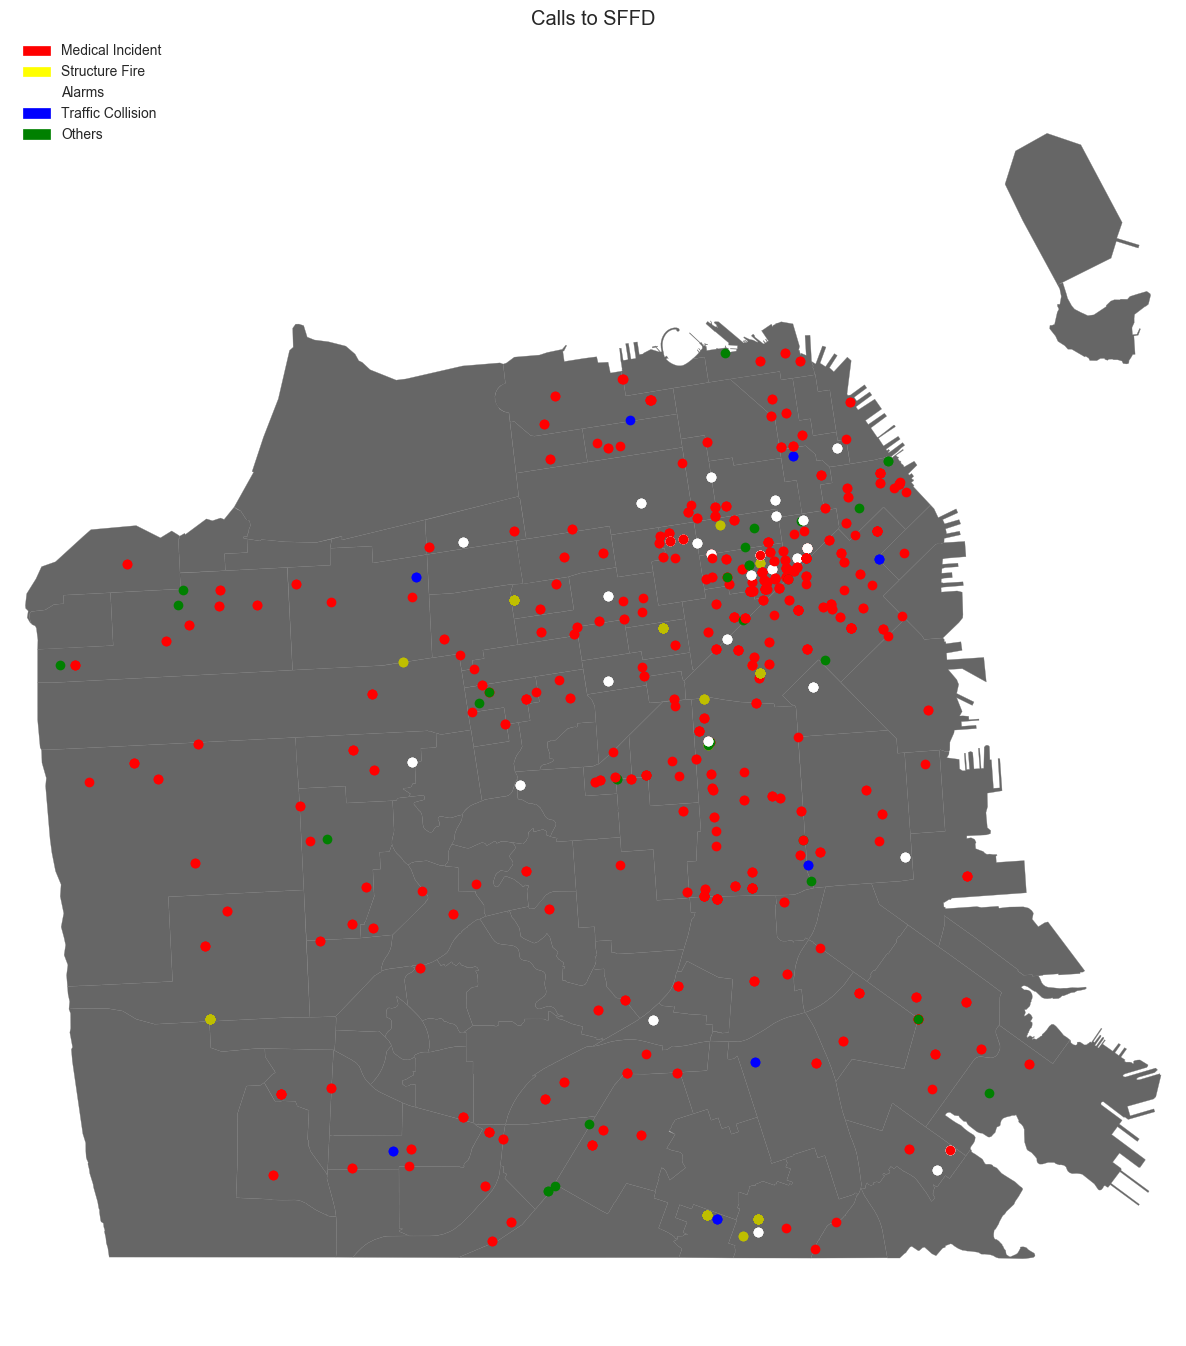

In [387]:
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.9,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

for lon, lat, clr in zip(longitude, latitude, call_type_clr):
    x,y = m(lon, lat)
    m.plot(x, y, clr)

ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

plt.title("Calls to SFFD")
red_patch = mpatches.Patch(color='red', label='Medical Incident')
yellow_patch = mpatches.Patch(color='yellow', label='Structure Fire')
white_patch = mpatches.Patch(color='white', label='Alarms')
blue_patch = mpatches.Patch(color='blue', label='Traffic Collision')
green_patch = mpatches.Patch(color='green', label='Others')
plt.legend(handles=[red_patch,yellow_patch,white_patch,blue_patch,green_patch],loc=2)
plt.tight_layout()

fig.set_size_inches(15, 15)
plt.show()